In [ ]:
import burnman
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy import constants

In [ ]:
G = constants.G.value
R_gas = constants.R.value
GPa = 1e9 #Pa
km = 1000 #m
den = 1000/100**3 #g/cm^-3
deg = 180/np.pi
rad = 1/deg
Me = constants.M_earth.value
Re = constants.R_earth.value
surface_T = 300 #K

In [ ]:
# 1. Definir material (olivino, forsterita)
forsterite = burnman.minerals.SLB_2011.forsterite()

# 2. Definir condiciones
P = 1e9   # presión en Pa (1 GPa)
T = 1500  # temperatura en K

# 3. Calcular propiedades termodinámicas
forsterite.set_state(P, T)
print("Densidad:", forsterite.density)
print("Bulk modulus:", forsterite.K_T /GPa)
print("Vp (km/s):", forsterite.v_p/1000)


Densidad: 3130.4984262283547
Bulk modulus: 106.21127021702377
Vp (km/s): 8.006002251487777


In [ ]:
from burnman import minerals, Composite, Layer, Planet

Radios

In [ ]:
planet_radius = Re

icb_radius = 1220e3  #núcleo interior
cmb_radius = 3480e3  #núcleo manto
lab_radius = planet_radius - 100e3 #base de la litosfera a 100 km de la superficie
moho_radius = planet_radius - 35e3   #Moho ~ 35 km


Capas

In [ ]:
inner_core_radii = np.linspace(0.0, icb_radius, 25)
outer_core_radii = np.linspace(icb_radius, cmb_radius, 25)
convecting_mantle_radii = np.linspace(cmb_radius, lab_radius, 101)
lith_mantle_radii = np.linspace(lab_radius, moho_radius, 31)
crust_radii = np.linspace(moho_radius, planet_radius, 21)

inner_core = Layer('inner core', radii=inner_core_radii)
outer_core = Layer('outer core', radii=outer_core_radii)
convecting_mantle = Layer('convecting mantle', radii=convecting_mantle_radii)
lithospheric_mantle = Layer('lithospheric mantle', radii=lith_mantle_radii)
crust = Layer('crust', radii=crust_radii)

Asignacion de Materiales

In [ ]:
#Nucleo
hcp_iron = minerals.SE_2015.hcp_iron()
liq_iron = minerals.SE_2015.liquid_iron()
inner_core.set_material(hcp_iron)
outer_core.set_material(liq_iron)

#Manto convectivo (bridgmanita + periclasa)
mg_bridg = minerals.SLB_2011.mg_bridgmanite()
periclase = minerals.SLB_2011.periclase()
convecting_mantle.set_material(Composite([mg_bridg, periclase], [0.8, 0.2]))

#Manto litosférico y corteza
dunite = minerals.SLB_2011.mg_fe_olivine(molar_fractions=[0.92, 0.08])
andesine = minerals.SLB_2011.plagioclase(molar_fractions=[0.4, 0.6])
lithospheric_mantle.set_material(dunite)
crust.set_material(andesine)


Temperatura y Presión

In [ ]:
#Adiabáticos para núcleos / manto profundo
inner_core.set_temperature_mode('adiabatic')
outer_core.set_temperature_mode('adiabatic')
convecting_mantle.set_temperature_mode('adiabatic', temperature_top=1600.0)

#Litosfera: geoterma conductiva
lab_temperature = 1550.0  # ejemplo (K) en la base de la litosfera
lith_temps = np.linspace(lab_temperature, 700.0, len(lithospheric_mantle.radii))
lithospheric_mantle.set_temperature_mode('user-defined', temperatures=lith_temps)

#Corteza
crust_temps = np.linspace(700.0, surface_T, len(crust.radii))
crust.set_temperature_mode('user-defined', temperatures=crust_temps)

Construccion del Planeta

In [ ]:
planet = Planet('MyEarthLike', [inner_core, outer_core,
                               convecting_mantle, lithospheric_mantle, crust],
                verbose=True)
planet.make()

Iteration 1 maximum relative pressure error: 9.6e-01
Iteration 2 maximum relative pressure error: 4.5e-01
Iteration 3 maximum relative pressure error: 1.7e-01
Iteration 4 maximum relative pressure error: 6.2e-02
Iteration 5 maximum relative pressure error: 2.2e-02
Iteration 6 maximum relative pressure error: 7.8e-03
Iteration 7 maximum relative pressure error: 2.7e-03
Iteration 8 maximum relative pressure error: 9.6e-04
Iteration 9 maximum relative pressure error: 3.4e-04
Iteration 10 maximum relative pressure error: 1.2e-04
Iteration 11 maximum relative pressure error: 4.2e-05
Iteration 12 maximum relative pressure error: 1.5e-05
Iteration 13 maximum relative pressure error: 5.1e-06


In [ ]:
r_all = np.array([])
p_all = np.array([])
rho_all = np.array([])
g_all = np.array([])
T_all = np.array([])

for layer in planet.layers:
    r_layer = layer.radii                 # radios (m)
    p_layer = layer.pressure              # presión (Pa)
    rho_layer = layer.density             # densidad (kg/m3)
    g_layer = layer.gravity               # gravity (m/s2)
    r_all = np.concatenate((r_all, r_layer))
    p_all = np.concatenate((p_all, p_layer))
    rho_all = np.concatenate((rho_all, rho_layer))
    g_all = np.concatenate((g_all, g_layer))
    T_all = np.concatenate((T_all, layer.temperatures))

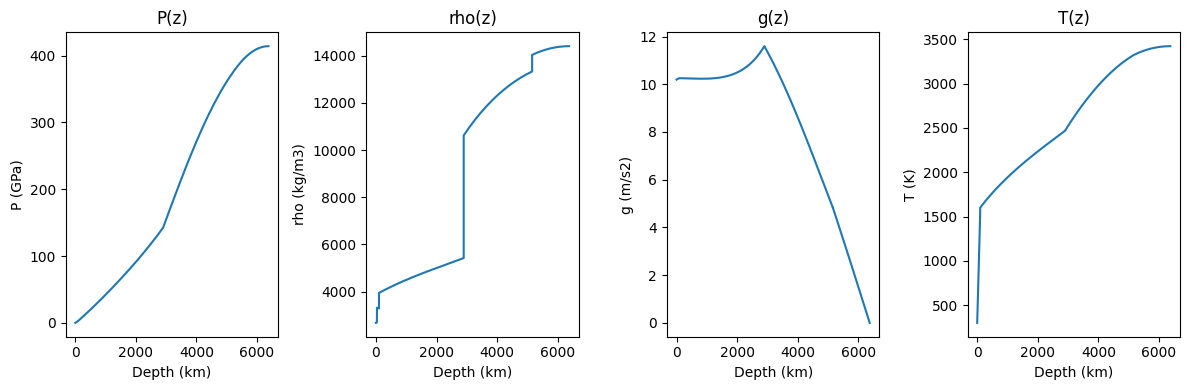

In [ ]:
depth = planet_radius - r_all       
mask = depth <= 100e3              
depth_km = depth[mask] / 1000.0


plt.figure(figsize=(12,4))
plt.subplot(1,4,1)
plt.plot(depth/km, p_all/GPa)
plt.ylabel('P (GPa)'); plt.xlabel('Depth (km)'); plt.title('P(z)')

plt.subplot(1,4,2)
plt.plot(depth/km, rho_all)
plt.ylabel('rho (kg/m3)');plt.xlabel('Depth (km)'); plt.title('rho(z)')

plt.subplot(1,4,3)
plt.plot(depth/km, g_all)
plt.ylabel('g (m/s2)');plt.xlabel('Depth (km)'); plt.title('g(z)')

plt.subplot(1,4,4)
plt.plot(depth/km, T_all)
plt.ylabel('T (K)');plt.xlabel('Depth (km)'); plt.title('T(z)')

plt.tight_layout()
plt.show()